# GRASP+PR

We can take the concepts of GRASP, elite sets and path relinking and combine them into a **hybrid** algorithm.


```python
def grasp_plus_pr(max_iterations, time_limit):
    best = []
    elite_set = []
    
    do 
        s = greedy_construction()
        s = local_search(s)

        if cost(s) > cost(best):
            best = s
            
        if len(elite_set) > 0:
            guiding = random(elite_set)
            s = path_relinking(s, guiding)
            
        update(s, elite_set)
        
    until max_iterations or time_limit
    
    return best
```

## Imports

In [1]:
import numpy as np
import sys
import time

## `metapy` imports

In [2]:
# install metapy if running in Google Colab
if 'google.colab' in sys.modules:
    !pip install meta-py

In [3]:
from metapy.tsp import tsp_io as io
from metapy.tsp.euclidean import gen_matrix, plot_tour

from metapy.tsp.objective import OptimisedSimpleTSPObjective

from metapy.local_search.hill_climbing import (HillClimber, TweakTwoOpt)

from metapy.tsp.grasp import (SemiGreedyConstructor,
                              FixedRCLSizer,
                              RandomRCLSizer,
                              MonitoredLocalSearch,
                              GRASP,
                              EliteSet)

## Load problem

In [4]:
#load file
file_path = 'https://raw.githubusercontent.com/TomMonks/meta-py/main/data/st70.tsp'

#number of rows in the file that are meta_data
md_rows = 6

#read the coordinates
cities = io.read_coordinates(file_path, md_rows)
matrix = gen_matrix(cities, as_integer=True)

## Implementation

* `TSPPathRelinker` implements forward or backward path relinking logic with the option to truncate the relinking after a fixed number of moves.
* `GRASPPlusPathRelinking` is an modification of the basic `GRASP` and adds path relinking plus an update of the elite set after each iteration.

In [5]:
class TSPPathRelinker:
    '''
    Path relinking for basic symmetric TSP.
    
    Performs forward or backward relinking with a random
    elite solution from the elite set.
    
    After PR is complete a local search is used to take the solution
    to a local optimum.
    '''
    def __init__(self, local_search, tracker, objective, 
                 trunc=None, random_seed=None):
        '''
        Constructor
        
        local_search: object
            local search algorithm
            
        tracker: EliteSet
            The elite set tracker object
            
        objective: object
            TSP Objective
            
        trunc: int, optional (default=None)
            Truncate the relinking to a fixed number of steps
            
        random_seed: int, optional (default=None)
            used to control sampling from elite set
        '''
        
        self.local_search = local_search
        self.tracker = tracker
        self.obj = objective
        self.trunc = trunc
        
        # used for selecting from the elite set at random
        self.rng = np.random.default_rng(random_seed)
        
        self.calls = 0
        self.made_it = 0
        self.already_elite = 0
    
    def evaluate_neighbour(self, from_city, current, guiding):
        '''
        Performs a two city swap and returns the cost.

        Params:
        ------
        from_city: int
            The city to swap

        current: np.ndarray
            The current solution

        guiding: np.ndarray
            The guiding solution

        obj: Object
            The TSP objective function

        Returns:
        -------
        float
        '''
        from_idx = np.where(current==from_city)[0][0]
        to_idx = np.where(guiding==from_city)[0][0]
        # swap and evaluate
        current[from_idx], current[to_idx] = current[to_idx], current[from_idx]
        cost= self.obj.evaluate(current)

        #swap back
        current[from_idx], current[to_idx] = current[to_idx], current[from_idx]
        return cost
    
    def next_restricted_neighbour_move(self, current, guiding):
        '''
        Iteratively search through a restricted neighbourhood based 
        on the guiding solution and greedily selects the best move.

        Params:
        -------
        current: np.ndarray
            The current solution

        guiding: np.ndarray
            The guiding solution

        obj: Object
            The TSP objective function

        Returns:
        -------
        (np.ndarray, float)
        (best_solution, best_cost) 
        '''
        # cities in the restricted neighbourhood

        swaps = current[current != guiding]
        
        costs = np.full(len(swaps), -np.inf)
        i = 0
        # is there a way to eliminate the python loop?
        for from_city in swaps:
            # evaluate all swaps in current restricted neighbourhood
            costs[i] = self.evaluate_neighbour(from_city, current, guiding)
            i += 1

        best_index = np.argmax(costs)
        from_city = swaps[best_index]

        # get index of cities in current and guiding solutions.
        from_idx = np.where(current==from_city)[0][0]
        to_idx = np.where(guiding==from_city)[0][0]
        # swap and evaluate
        current[from_idx], current[to_idx] = current[to_idx], current[from_idx]
        return current, costs[best_index]
    
    def relink(self, solution, elite_solution=None, direction='backward'):
        '''
        Relink between a current and guiding solution
        
        Params:
        -------
        solution: np.ndarray
            a none elite set TSP solution
            
        elite_solution: np.ndarray.
            guiding TSP solution
            
        direction: str
             forward: move from current towards guiding
             backward: swap current and guiding and relink.
        '''
        
        # catch local optimum solutions that are already elite
        if self.tracker.is_elite(solution):
            self.already_elite += 1
            return solution, self.obj.evaluate(solution)
        
        # random elite solution if none specified
        if elite_solution is None:
            elite_solution = self.rng.choice(self.tracker.solutions)
        
        # if 'forward' selected.
        if direction == 'forward':
            current, guiding = solution, elite_solution
        elif direction == 'backward':
            current, guiding = elite_solution, solution
        else:
            raise ValueError('Please select backward of forward relinking')
        
        # moves to relink n / 2
        n_moves = len(current[current != guiding]) // 2

        # used to truncate path relinking
        if self.trunc is not None:
            if self.trunc > n_moves:
                raise ValueError(f'@trunc must be <= moves to relink {n_moves}')
            else:
                n_moves = self.trunc

        # path relinking
        costs = [self.obj.evaluate(solution)]
        solutions = [solution]
        for i in range(n_moves):
            current, cost = self.next_restricted_neighbour_move(current.copy(), 
                                                                guiding)
            solutions.append(current)
            costs.append(cost)

        # best solution and cost
        # error here if the relinking has found no improvements.
        best_idx = np.array(costs).argmax()
        pr_solution, pr_cost =  solutions[best_idx], costs[best_idx]
        
        # local search on relinked solution...
        self.local_search.set_init_solution(pr_solution)
        self.local_search.solve()
        
        # return local optimum
        return self.local_search.best_solutions[0], self.local_search.best_cost

In [6]:
class GRASPPlusPathRelinking:
    '''
    Greedy Randomised Adaptive Search Procedure algorithm
    hybridised with Path RelinkiGRASPPlusPathRelinkingng for the Travelling Salesman Problem
    '''
    def __init__(self, constructor, local_search, relinker,
                 tracker, max_iter=1000, time_limit=np.inf):
        
        # semi greedy tour construction method
        self.constructor = constructor
        
        # local search procedure
        self.local_search = local_search
        
        # path relinker
        self.path_relinker = relinker
        
        # elite solution tracker
        self.elite_tracker = tracker
        
        # max runtime budget for GRASP
        self.max_iter = max_iter
        self.time_limit = time_limit
        
        # init solution 
        self.best_solution = None
        self.best = None
    
        
    def solve(self):
        '''
        Run GRASP
        
        Returns:
        -------
        None
        '''
        self.best_solution = None
        self.best = -np.inf
        
        i = 0
        start = time.time()
        while i < self.max_iter and ((time.time() - start) < self.time_limit): 
            i += 1
            
            # construction phase
            solution = self.constructor.build()
            
            # Improve solution via local search
            self.local_search.set_init_solution(solution)
            self.local_search.solve()
            
            current_solution = self.local_search.best_solutions[0]
            current_cost = self.local_search.best_cost
            
            if not self.elite_tracker.is_empty:
                # backwards path relinking with elite solution selected at random
                current_solution, current_cost = self.path_relinker.relink(current_solution)
            
            # added because in theory best solution might not go into Elite set due to diversity
            if current_cost > self.best:
                self.best = current_cost
                self.best_solution = current_solution
            
            # update elite solutions
            self.elite_tracker.update(current_solution, current_cost)

In [11]:
def compose_grasp(tour, maxtrix, max_iter=50, elite_set_size=10, rcl_size=5, 
                  trunc=15, seeds=(None, None)):


    # objective function
    obj = OptimisedSimpleTSPObjective(-matrix)

    # Two-opt tweaks
    tweaker = TweakTwoOpt()

    # local search for main GRASP = first improvement hill climbing
    ls1 = HillClimber(obj, tour, tweaker)

    # local search for path relinking = first improvement hill climbing
    ls2 = HillClimber(obj, tour, tweaker)

    # semi-greedy constructor and RCL sizer
    sizer = FixedRCLSizer(rcl_size)
    
    constructor = SemiGreedyConstructor(sizer, tour, -matrix, 
                                        random_seed=seeds[0])

    # elite set tracker
    tracker = EliteSet(min_delta=1, max_size=elite_set_size)

    # path relinking logic
    relinker = TSPPathRelinker(ls2, tracker, obj, trunc=trunc, random_seed=seeds[1])

    # GRASP + PR framework
    solver = GRASPPlusPathRelinking(constructor, ls1, relinker, tracker, 
                                    max_iter=max_iter)
    
    return solver


Running GRASP+PR

** GRASP OUTPUT ***
best cost:	-703.0
best solutions:
[ 0 35 28 12 69 34 68 30 37 58 21 65 62 56 14 23 18 25 54 48 27  7  2 31
  6  1  3 17  5 40 41 43 13 19 29 26 45 44 24 38 60 39  8 67 42 16 20 33
 11 32 61 53 47 66 10 63 64 55 50 59 51  9  4 52 49 57 36 46 15 22]


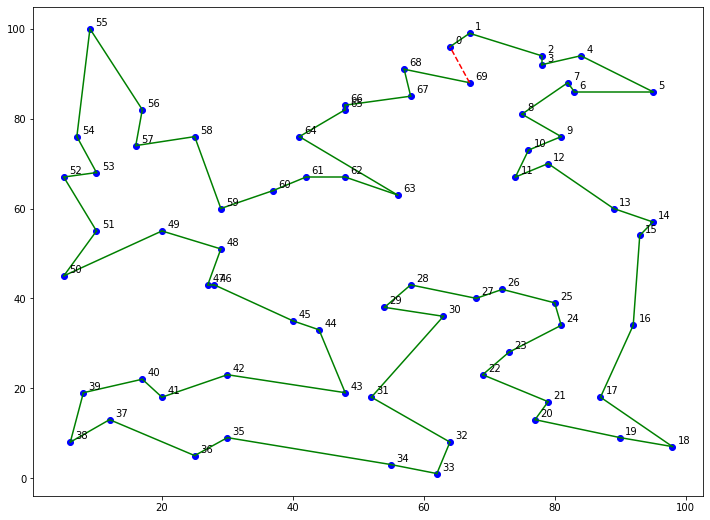

In [17]:
tour = np.arange(len(cities))
solver = compose_grasp(tour, matrix, max_iter=50, seeds=(42, 1966), 
                       rcl_size=10)
print("\nRunning GRASP+PR")
solver.solve()

print("\n** GRASP OUTPUT ***")
print(f"best cost:\t{solver.best}")
print("best solutions:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))